In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'sample_submission.csv', 'test']


Necassary Imports

In [2]:
import pandas as pd
import os,cv2
from IPython.display import Image
from keras.preprocessing import image
from keras import optimizers
from keras import layers,models
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121, DenseNet169, DenseNet201
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import numpy as np

Using TensorFlow backend.


Specifying training and test directories

In [3]:
train_dir = '../input/train'
test_dir = '../input/test'
submission = pd.read_csv('../input/sample_submission.csv')

In [4]:
categories = os.listdir(train_dir)
categories

['Fat Hen',
 'Sugar beet',
 'Small-flowered Cranesbill',
 'Maize',
 'Black-grass',
 'Cleavers',
 'Scentless Mayweed',
 'Common wheat',
 'Common Chickweed',
 'Shepherds Purse',
 'Loose Silky-bent',
 'Charlock']

**Displaying one image from each category** 

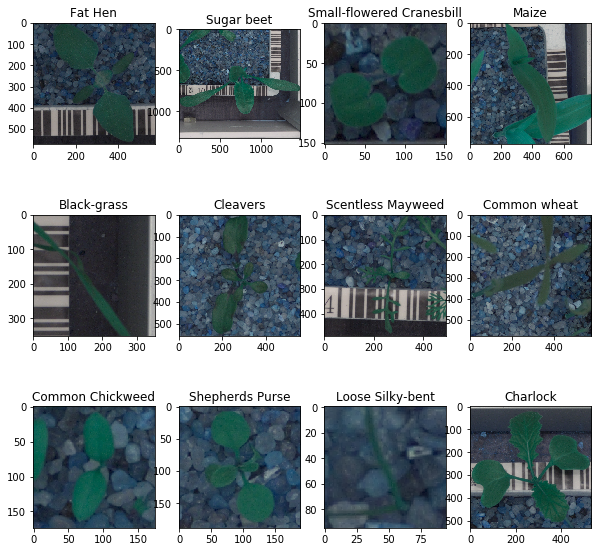

In [5]:
i=0
images = []
for i in range(0,12):
    image = os.listdir(os.path.join(train_dir,categories[i]))
    img = cv2.imread(train_dir + '/' + categories[i] + '/' + image[i])
    images.append(img)
    i = i+1
    
plt.figure(figsize=[10,10])
for x in range(0,12):
    plt.subplot(3, 4,x+1)
    plt.imshow(images[x])
    plt.title(categories[x])
    x += 1
    
plt.show()

In [6]:
len(images)

12

Reading train and test data into pandas dataframes

In [7]:
train = []
for species_id, sp in enumerate(categories):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train.append(['train/{}/{}'.format(sp, file), file, species_id, sp])
train_df = pd.DataFrame(train, columns=['filepath', 'file', 'species_id', 'species'])

print('train_df.shape = ', train_df.shape)

# read all test data
test = []
for file in os.listdir(test_dir):
    test.append(['../input/test/{}'.format(file), file])
test_df = pd.DataFrame(test, columns=['filepath', 'file'])
print('test_df.shape = ', test_df.shape)

train_df.shape =  (4750, 4)
test_df.shape =  (794, 2)


In [8]:
train_df.head()


,filepath,file,species_id,species
0,train/Fat Hen/e3279d465.png,e3279d465.png,0,Fat Hen
1,train/Fat Hen/aa4c94174.png,aa4c94174.png,0,Fat Hen
2,train/Fat Hen/326c83b87.png,326c83b87.png,0,Fat Hen
3,train/Fat Hen/13d56e652.png,13d56e652.png,0,Fat Hen
4,train/Fat Hen/1e9c7a82f.png,1e9c7a82f.png,0,Fat Hen


In [9]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

train_df.head()

,filepath,file,species_id,species
0,train/Sugar beet/4e96e4f63.png,4e96e4f63.png,1,Sugar beet
1,train/Common Chickweed/51122ffd7.png,51122ffd7.png,8,Common Chickweed
2,train/Common Chickweed/151a67732.png,151a67732.png,8,Common Chickweed
3,train/Maize/b62a6a471.png,b62a6a471.png,3,Maize
4,train/Shepherds Purse/0ddeaa6e7.png,0ddeaa6e7.png,9,Shepherds Purse


In [10]:
from keras.preprocessing import image

Importing and creating training and test arrays

In [11]:
data_dir = '../input'
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

In [12]:
test_df.head()


,filepath,file
0,../input/test/0d31e6602.png,0d31e6602.png
1,../input/test/5bc6595f6.png,5bc6595f6.png
2,../input/test/31fcdc161.png,31fcdc161.png
3,../input/test/1541bdb2e.png,1541bdb2e.png
4,../input/test/089ad62a7.png,089ad62a7.png


Training data is augmented using keras.ImageDataGenerator

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory = '../input/train',
    target_size = (256,256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=1978
    )



Found 4750 images belonging to 12 classes.


We use a pretrained ResNet50 with imagenet weights. We exclude the top and replace it with our own Dense Layers

In [14]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(256, 256, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 252, 252, 64)      4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 252, 252, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 248, 248, 64)      102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
dropout_1 (Dropout)  

Building the model - Simple CNN

In [15]:
history = model.fit_generator(train_generator,
steps_per_epoch = 1000,
epochs = 25,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
1000/1000 [==============================] - 898s 898ms/step - loss: 1.4661 - acc: 0.5346
Epoch 2/25
1000/1000 [==============================] - 857s 857ms/step - loss: 0.7389 - acc: 0.7464
Epoch 3/25
1000/1000 [==============================] - 846s 846ms/step - loss: 0.5647 - acc: 0.8072
Epoch 4/25
1000/1000 [==============================] - 845s 845ms/step - loss: 0.4553 - acc: 0.8439
Epoch 5/25
1000/1000 [==============================] - 849s 849ms/step - loss: 0.3871 - acc: 0.8682
Epoch 6/25
1000/1000 [==============================] - 841s 841ms/step - loss: 0.3306 - acc: 0.8842
Epoch 7/25
1000/1000 [==============================] - 840s 840ms/step - loss: 0.2861 - acc: 0.9039
Epoch 8/25
1000/1000 [==============================] - 835s 835ms/step - loss: 0.2533 - acc: 0.9153
Epoch 9/25
1000/1000 [==============================] - 831s 831ms/step - loss: 0.2328 - acc: 0.9200
Epoch 10/25
1000/1000 [====================

In [16]:
model.save('ResNet50Keras.h5')

In [17]:
test_generator = test_datagen.flow_from_dataframe(
test_df,
directory = None,
x_col = 'filepath',
y_col = None,
class_mode = None,
target_size = (256,256),
batch_size = 64
)


Found 794 images.


In [18]:
predict = model.predict_generator(test_generator,steps=np.ceil(test_df.shape[0]/64))
len(predict)

794

In [19]:
submission['file'].shape
test_df['file'].shape

(794,)

In [20]:
predict[0]

array([1.2518413e-03, 8.3679896e-10, 9.3170991e-09, 7.6537859e-08,
       9.4959034e-08, 1.1756640e-08, 9.9873680e-01, 2.7393546e-06,
       8.0482696e-06, 3.8190286e-09, 3.8198667e-07, 7.1429591e-09],
      dtype=float32)

Creating submission style and csv file

In [21]:
pred = np.argmax(predict,axis=1)

pred_class = []
for i in pred:
    pred_class.append(categories[pred[i]])
    

In [22]:
len(pred_class)
pred_class

['Scentless Mayweed',
 'Fat Hen',
 'Shepherds Purse',
 'Shepherds Purse',
 'Common wheat',
 'Common wheat',
 'Scentless Mayweed',
 'Common Chickweed',
 'Scentless Mayweed',
 'Fat Hen',
 'Scentless Mayweed',
 'Fat Hen',
 'Common wheat',
 'Common Chickweed',
 'Common wheat',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Common wheat',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Common Chickweed',
 'Shepherds Purse',
 'Maize',
 'Common wheat',
 'Scentless Mayweed',
 'Common wheat',
 'Common Chickweed',
 'Scentless Mayweed',
 'Common Chickweed',
 'Maize',
 'Common wheat',
 'Scentless Mayweed',
 'Common wheat',
 'Maize',
 'Common wheat',
 'Scentless Mayweed',
 'Maize',
 'Common Chickweed',
 'Small-flowered Cranesbill',
 'Fat Hen',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Fat Hen',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Small-flowered Cranesbill',
 'Common wheat',
 'Common wheat',
 'Maize',
 'Maize',
 'Scentless Mayweed',
 'Scentless Ma

In [23]:
result = {'file':test_df['file'],'species':pred_class}
result = pd.DataFrame(result)
result.to_csv("submission.csv",index=False)

In [24]:
result.head()

,file,species
0,0d31e6602.png,Scentless Mayweed
1,5bc6595f6.png,Fat Hen
2,31fcdc161.png,Shepherds Purse
3,1541bdb2e.png,Shepherds Purse
4,089ad62a7.png,Common wheat
